## Fitting hMFC to an empirical dataset

In [1]:
from jax import vmap
import jax.numpy as jnp
import jax.random as jr
from jax.nn import sigmoid
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from fastprogress import progress_bar
import numpy as np
import dill
from matplotlib.backends.backend_pdf import PdfPages

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

from hmfc.model import HierarchicalBernoulliLDS
from hmfc.gibbs import gibbs_step

In [2]:
sns.set_theme(style="ticks", context="paper",
        rc={"axes.titlesize": 16,
            "axes.labelsize": 14,
            "xtick.labelsize": 12,
            "ytick.labelsize": 12,
            "axes.spines.right": False,
            "axes.spines.top": False
            })

### Load in Dataset

In [3]:
""" Load in dataset

    Should be in long format. Following columns have to be present:
        'subj': indicating subject number
        'resp': indicating the responses or emissions (IMPORTANT: should be 0 and 1, and rows with missing values should be removed)
         Additional input variables you want to include as predictor in the model (e.g. stimulus, previous response,...)
         Binary variables should be transformed to -1 and 1, continuous variables are prefeably also scaled between -1 and 1.
         Interactions should be in the dataset itself (i.e., one column where two variables are multiplied)
        
    num_inputs:
        Indicate number of input variables that will be used in the model.
        Basically, how many predictors do you want to use to predict 'response'.
        For example: stimulus, previous resp, previous stimulus -> num_input = 3
    
"""
dataset = 'Yeon_unpub_Exp2'

data = pd.read_csv(f"/vsc-hard-mounts/leuven-data/343/vsc34314/hMFC and confidence/{dataset}.csv")
num_inputs = 5 # stimulus, prev resp, prev conf, prev resp conf (interaction), prev stimulus



### Put dataset in correct data structure

In [4]:
""" 
    We also have to create a 'mask' variable. This variable helps the model to deal with varying numbers of trials per subject.
    The masks variable indicates which data points in the emissions (responses) array are valid and which are padded 
    (i.e., added to make all subjects have the same number of trials). 
    
"""


num_trials_per_subject = jnp.array(data.groupby('subj').size())
max_num_trials = data.groupby('subj').size().max()  # Find the maximum number of observations
num_trials = max_num_trials # Set to number trials of subject with most trials, masking takes care of the other subjects

inputs, emissions, masks = [], [], []

for i in np.unique(data.subj):
    df = data[data.subj == i]

    """ 
    IMPORTANT 
    
    Adjust the names of the variables below according to your dataset (df.evidence, df.prev_evidence, df.prev_resp) and add them to inputs_subj
    
    """
        
    evidence = jnp.array(df.evidence)  # scaled between -1 and 1
    prevsignabsevi = jnp.array(df.prevsignabsevi)  # interaction prevsign and prevabsevi
    prevresp = jnp.array(df.prevresp)  # -1 left, 1 right
    prevconf = jnp.array(df.prevconf)  # continuous scale between -1 and 1
    prevrespconf = jnp.array(df.prevrespconf)  # interaction between prevresp and prevconf

    resp = jnp.array(df.resp)

    inputs_subj = jnp.vstack([evidence, prevsignabsevi, prevresp, prevconf, prevrespconf]).T
    
    # MEAN CENTERING THE INPUTS! Required for hMFC
    inputs_subj = inputs_subj - jnp.mean(inputs_subj, axis=0)
    emissions_subj = resp
    
    # Create masking variable
    masks_subj = jnp.ones_like(emissions_subj)

    # Check if the subject has fewer observations than the maximum
    if df.shape[0] < max_num_trials:
        # Calculate the number of observations to fill
        num_to_fill = max_num_trials - df.shape[0]
        # Create a matrix of zeros to fill in the missing observations
        zero_input = jnp.zeros((num_to_fill, num_inputs))
        zero_emissions = jnp.zeros(num_to_fill)

        # Append the zero-filled observations
        inputs_subj = jnp.vstack([inputs_subj, zero_input])
        emissions_subj = jnp.concatenate((emissions_subj, zero_emissions))
        masks_subj = jnp.concatenate((masks_subj, zero_emissions))

    # Append the results to the output lists
    inputs.append(inputs_subj)
    emissions.append(emissions_subj)
    masks.append(masks_subj)

# Convert the lists to arrays
inputs = jnp.array(inputs)
emissions = jnp.array(emissions)
masks = jnp.array(masks)

num_subjects = len(inputs)

### Initialize some variables

In [5]:
"""
    num_chains: number of chains to run in parallel for the estimation procedure
    num_iters: number of iterations for the estimation procedure

"""

num_chains = 4
num_iters = 5000

### Fit model

In [6]:
def initialize_and_fit_model(key):
    
    """
    Initialize model
    """
    key = jr.PRNGKey(key) if isinstance(key, int) else key
    k1, k2, k3, k4, k5, k6, k7 = jr.split(key, 7)
     
    init_mu_w = tfd.Uniform(-1.0, 1.0).sample(seed=k1, sample_shape=(num_inputs,))
    init_sigma_w = tfd.Uniform(0.1, 1.0).sample(seed=k2, sample_shape=(num_inputs,))
    init_mu_a = tfd.Uniform(0.5, 0.995).sample(seed=k3)
    init_sigma_a = tfd.Uniform(0.1, 0.2).sample(seed=k4) # there is an upper limit for sigma_a, so don't exceed 0.2, otherwise parameter is not updated!
    init_mu_sigmasq = 0.15
    init_beta_sigmasq = 0.15
    init_sigma_mu_x = tfd.Uniform(0.1, 0.5).sample(seed=k7)
    
    model = HierarchicalBernoulliLDS(num_inputs, init_mu_a, init_sigma_a, init_mu_w, init_sigma_w, init_mu_sigmasq, init_beta_sigmasq, init_sigma_mu_x)
    params, states, _ = model.sample(key, inputs) # sample initial per-subject parameters and states (criterion trajectory)


    """
    Fit model
    """
    lps = jnp.zeros((num_iters,)) # log probability
    
    posterior_samples_mu_a = jnp.zeros((num_iters,))
    posterior_samples_sigma_a = jnp.zeros((num_iters,))
    posterior_samples_mu_w = jnp.zeros((num_iters, num_inputs))
    posterior_samples_sigma_w = jnp.zeros((num_iters, num_inputs))
    posterior_samples_mu_sigmasq = jnp.zeros((num_iters,))
    posterior_samples_beta_sigmasq = jnp.zeros((num_iters,))
    posterior_samples_sigma_mu_x = jnp.zeros((num_iters,))
    
    posterior_samples_a = jnp.zeros((num_iters, num_subjects))
    posterior_samples_sigmasq = jnp.zeros((num_iters, num_subjects))
    posterior_samples_w = jnp.zeros((num_iters, num_subjects, num_inputs))
    posterior_samples_mu_x = jnp.zeros((num_iters, num_subjects))

    posterior_samples_states = jnp.zeros((num_iters, num_subjects, num_trials))
    
    for itr in progress_bar(range(num_iters)):

        this_key, key = jr.split(key)
        lp, states, params, model = gibbs_step(this_key, emissions, masks, states, inputs, params, model, update_global_mu_sigmasq=False, update_global_beta_sigmasq=False)
        
        lps = lps.at[itr].set(lp)

        posterior_samples_mu_a = posterior_samples_mu_a.at[itr].set(sigmoid(model.logit_mu_a))
        posterior_samples_sigma_a = posterior_samples_sigma_a.at[itr].set(jnp.exp(model.log_sigma_a))
        posterior_samples_mu_w = posterior_samples_mu_w.at[itr].set(model.mu_w)
        posterior_samples_sigma_w = posterior_samples_sigma_w.at[itr].set(jnp.exp(model.log_sigma_w))
        posterior_samples_mu_sigmasq = posterior_samples_mu_sigmasq.at[itr].set(jnp.exp(model.log_mu_sigmasq))
        posterior_samples_beta_sigmasq = posterior_samples_beta_sigmasq.at[itr].set(jnp.exp(model.log_beta_sigmasq))
        posterior_samples_sigma_mu_x = posterior_samples_sigma_mu_x.at[itr].set(jnp.exp(model.log_sigma_mu_x))


        posterior_samples_a = posterior_samples_a.at[itr].set(params['a'])
        posterior_samples_sigmasq = posterior_samples_sigmasq.at[itr].set(params['sigmasq'])
        posterior_samples_w = posterior_samples_w.at[itr].set(params['w'])
        posterior_samples_mu_x = posterior_samples_mu_x.at[itr].set(params['mu_x'])
        
        posterior_samples_states = posterior_samples_states.at[itr].set(states)
    

    return posterior_samples_mu_a, posterior_samples_sigma_a, posterior_samples_mu_w, posterior_samples_sigma_w, posterior_samples_mu_sigmasq, posterior_samples_beta_sigmasq, posterior_samples_sigma_mu_x, posterior_samples_a, posterior_samples_sigmasq, posterior_samples_w, posterior_samples_mu_x, posterior_samples_states, lps


### Run multiple chains in parallel

In [7]:
keys = jr.split(jr.PRNGKey(2), num_chains)

posterior_samples_mu_a, posterior_samples_sigma_a, posterior_samples_mu_w, posterior_samples_sigma_w, posterior_samples_mu_sigmasq, posterior_samples_beta_sigmasq, posterior_samples_sigma_mu_x, posterior_samples_a, posterior_samples_sigmasq, posterior_samples_w, posterior_samples_mu_x, posterior_samples_states, lps = vmap(initialize_and_fit_model)(keys)

### Save variables

In [8]:
file_name = f'/vsc-hard-mounts/leuven-data/343/vsc34314/hMFC and confidence/{dataset}.dil'

list_of_variable_names = ("lps", 
  "posterior_samples_mu_a", "posterior_samples_sigma_a",
  "posterior_samples_mu_sigmasq", "posterior_samples_beta_sigmasq",
  "posterior_samples_mu_w", "posterior_samples_sigma_w",
  "posterior_samples_sigma_mu_x", "posterior_samples_mu_x",
  "posterior_samples_a","posterior_samples_sigmasq",
  "posterior_samples_w", "posterior_samples_states",
  "num_trials", "num_inputs","num_trials_per_subject","num_subjects","num_iters", "inputs", "emissions", "masks")


with open(file_name, 'wb') as file:
    dill.dump(list_of_variable_names, file)  # Store all the names first
    
    for variable_name in list_of_variable_names:
        dill.dump(eval(variable_name), file) # Store the objects themselves

### Load in variables

In [9]:
file_name = f'/vsc-hard-mounts/leuven-data/343/vsc34314/hMFC and confidence/{dataset}.dil'

g = globals()
with open(file_name,'rb') as file:
    list_of_variable_names = dill.load(file)  # Get the names of stored objects
    for variable_name in list_of_variable_names:
        g[variable_name] = dill.load(file)    # Get the objects themselves

### Log joint probability

In [10]:
burn_in = 500

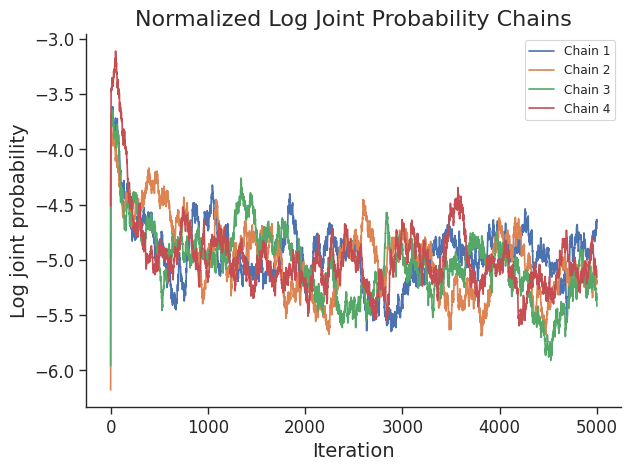

In [11]:
""" 
Check log joint probability to assess convergence and determine number of burn-in iterations

Ideally, the log joint probability should stabilize and fluctuate around a certain value for a couple of hundereds iterations.
If it is still clearly increasing then rerun the model with more iterations. The first iterations where the log joint probability
is still increasing should be considered burn-in.
"""

for i in range(lps.shape[0]):
    plt.plot(lps[i]/emissions.size, label=f'Chain {i + 1}') 

plt.xlabel("Iteration")
plt.ylabel("Log joint probability")
plt.title("Normalized Log Joint Probability Chains") 
plt.legend() 
plt.tight_layout()
plt.show()

### Per-subject parameters

#### Slopes input variables $w_i$

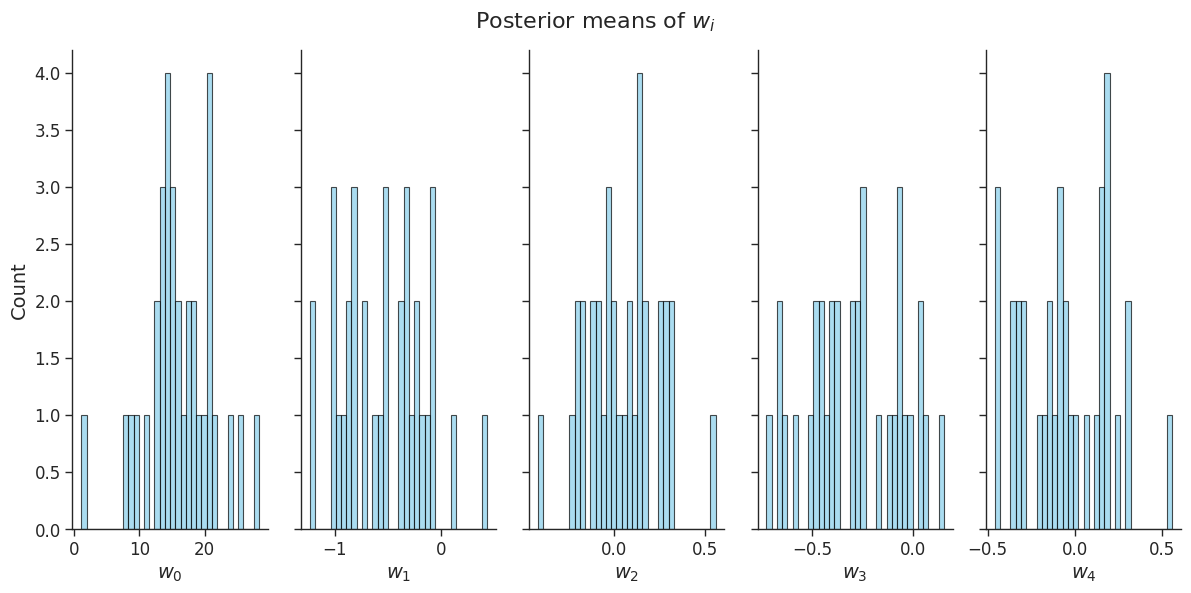

In [12]:
post_w = posterior_samples_w[:,burn_in:,:,:] # (num_chains, num_iterations, num_subjects, num_inputs)
post_w = post_w.reshape(-1, num_subjects, num_inputs) # collapse samples over the chains

fig, axs = plt.subplots(1, num_inputs, sharey=True, figsize=(12, 6))
for d, ax in enumerate(axs):
    ax.hist(jnp.mean(post_w[:,:,d], axis=0), bins=num_subjects, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_xlabel(r"$w_{:d}$".format(d))
    if d == 0: ax.set_ylabel("Count")
plt.suptitle(r"Posterior means of $w_i$", fontsize=16)
plt.tight_layout()
plt.show()

#### Autoregressive coefficient $a_i$

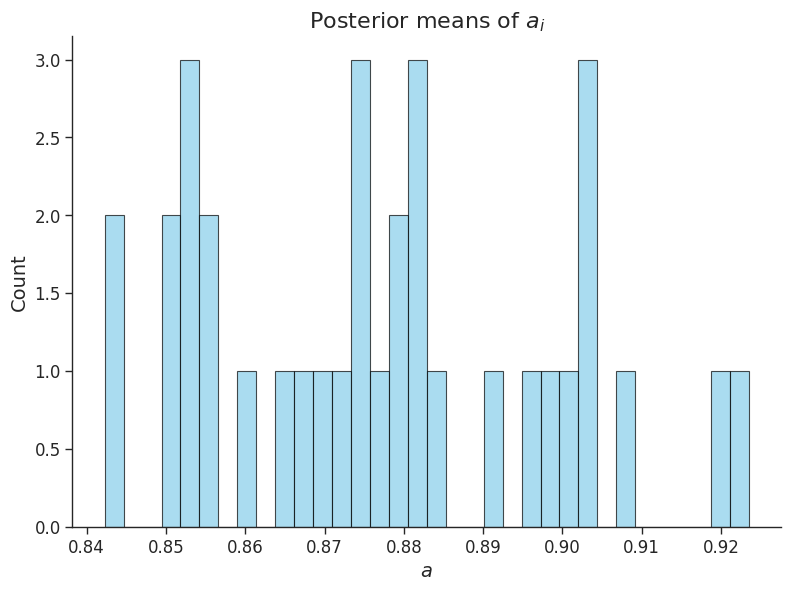

In [13]:
post_a = posterior_samples_a[:,burn_in:,:] # (num_chains, num_iterations, num_subjects)
post_a = post_a.reshape(-1, num_subjects) # collapse samples over the chains

plt.figure(figsize=(8, 6))
plt.hist(jnp.mean(post_a, axis=0), bins=num_subjects, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel(r"$a$")
plt.ylabel("Count")
plt.title(r"Posterior means of $a_i$")
plt.tight_layout()
plt.show()

#### Error variance $\sigma^2_i$

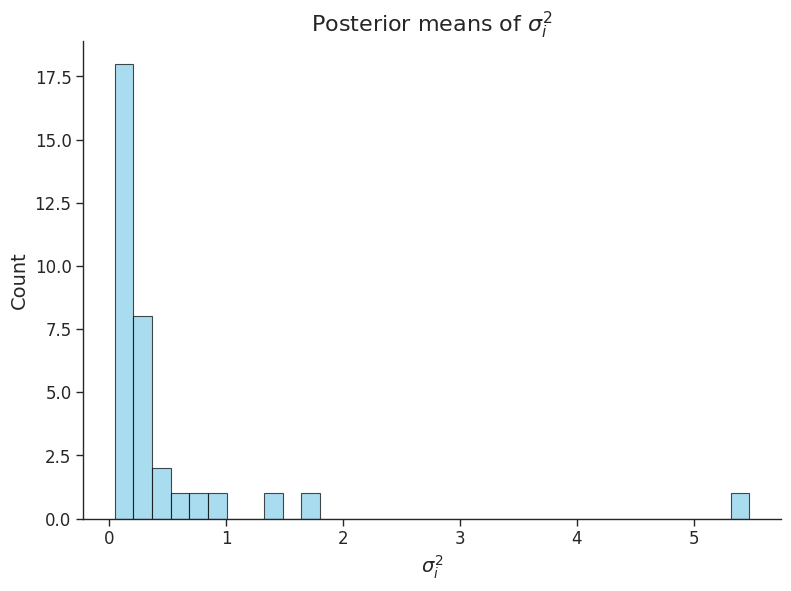

In [14]:
post_sigmasq = posterior_samples_sigmasq[:,burn_in:,:] # (num_chains, num_iterations, num_subjects)
post_sigmasq = post_sigmasq.reshape(-1, num_subjects) # collapse samples over the chains

plt.figure(figsize=(8, 6))
plt.hist(jnp.mean(post_sigmasq, axis=0), bins=num_subjects, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel(r"$\sigma^2_i$")
plt.ylabel("Count")
plt.title(r"Posterior means of $\sigma^2_i$")
plt.tight_layout()
plt.show()

#### Criterion mean $\mu_{x,i}$

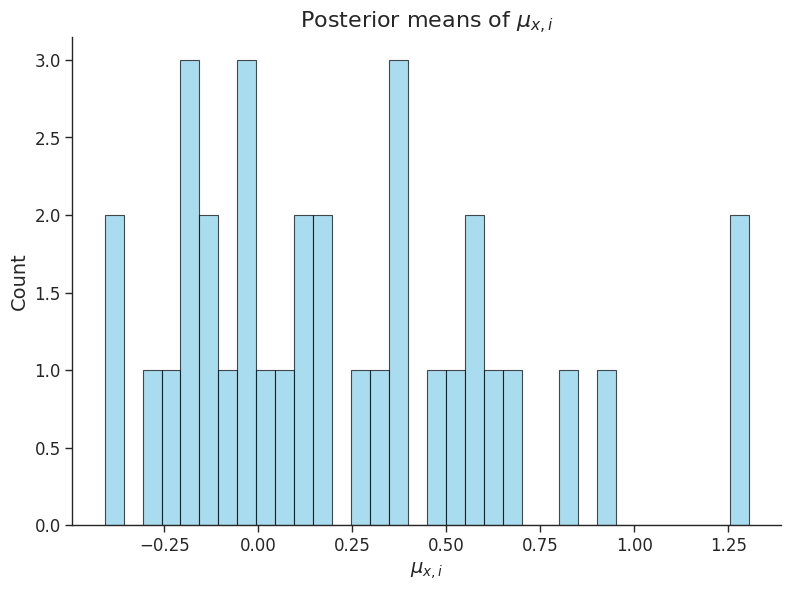

In [15]:
post_mu_x = posterior_samples_mu_x[:,burn_in:,:] # (num_chains, num_iterations, num_subjects)
post_mu_x = post_mu_x.reshape(-1, num_subjects) # collapse samples over the chains

plt.figure(figsize=(8, 6))
plt.hist(jnp.mean(post_mu_x, axis=0), bins=num_subjects, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel(r"$\mu_{x,i}$")
plt.ylabel("Count")
plt.title(r"Posterior means of $\mu_{x,i}$")
plt.tight_layout()
plt.show()

### Criterion fluctuations

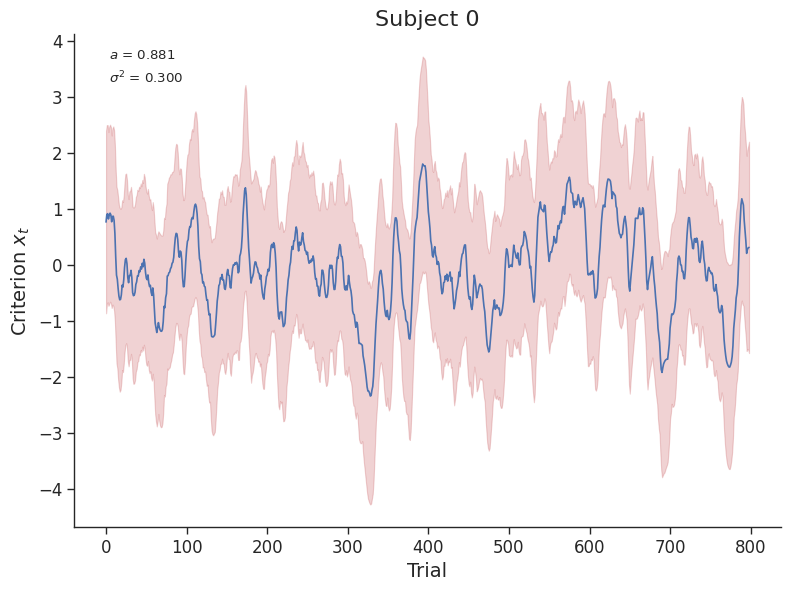

In [16]:
example_subject = 0

post_states = posterior_samples_states[:,burn_in:,:,:] # (num_chains, num_iterations, num_subjects, num_trials)
post_states = post_states.reshape(-1, num_subjects, num_trials) # collapse samples over the chains

posterior_samples_states_mean = jnp.mean(post_states[:,:,:], axis=0) 
posterior_samples_states_std = jnp.std(post_states[:,:,:], axis=0)

post_a = posterior_samples_a[:,burn_in:,:] # (num_chains, num_iterations, num_subjects)
post_a = post_a.reshape(-1, num_subjects) # collapse samples over the chains

post_sigmasq = posterior_samples_sigmasq[:,burn_in:,:] # (num_chains, num_iterations, num_subjects)
post_sigmasq = post_sigmasq.reshape(-1, num_subjects) # collapse samples over the chains


plt.figure(figsize=(8, 6))
plt.plot(posterior_samples_states_mean[example_subject], label="Inferred states")
plt.fill_between(jnp.arange(num_trials), #95% CI
            posterior_samples_states_mean[example_subject] - 2 * posterior_samples_states_std[example_subject],
            posterior_samples_states_mean[example_subject] + 2 * posterior_samples_states_std[example_subject], color='r', alpha=0.25)
plt.xlabel("Trial")
plt.ylabel("Criterion $x_t$")
plt.annotate(r'$a$ = {:.3f}'.format(jnp.mean(post_a, axis=0)[example_subject]), xy=(0.05, 0.95), xycoords='axes fraction')
plt.annotate(r'$\sigma^2$ = {:.3f}'.format(jnp.mean(post_sigmasq, axis=0)[example_subject]), xy=(0.05, 0.9), xycoords='axes fraction')
plt.title(r"Subject {:d}".format(example_subject))
plt.tight_layout()

In [17]:
"""
Create pdf of all subjects
"""

post_states = posterior_samples_states[:,burn_in:,:,:] # (num_chains, num_iterations, num_subjects, num_trials)
post_states = post_states.reshape(-1, num_subjects, num_trials) # collapse samples over the chains

posterior_samples_states_mean = jnp.mean(post_states[:,:,:], axis=0) 
posterior_samples_states_std = jnp.std(post_states[:,:,:], axis=0)

post_a = posterior_samples_a[:,burn_in:,:] # (num_chains, num_iterations, num_subjects)
post_a = post_a.reshape(-1, num_subjects) # collapse samples over the chains

post_sigmasq = posterior_samples_sigmasq[:,burn_in:,:] # (num_chains, num_iterations, num_subjects)
post_sigmasq = post_sigmasq.reshape(-1, num_subjects) # collapse samples over the chains

with PdfPages(f'{dataset}_estimated_criterion_trajectory.pdf') as pdf:
  for subject in range(num_subjects):
      
      plt.figure(figsize=(8, 6))
      plt.plot(posterior_samples_states_mean[subject], label="Inferred states")
      plt.fill_between(jnp.arange(num_trials), #95% CI
                  posterior_samples_states_mean[subject] - 2 * posterior_samples_states_std[subject],
                  posterior_samples_states_mean[subject] + 2 * posterior_samples_states_std[subject], color='r', alpha=0.25)
      plt.xlabel("Trial")
      plt.ylabel("Criterion $x_t$")
      plt.annotate(r'$a$ = {:.3f}'.format(jnp.mean(post_a, axis=0)[subject]), xy=(0.05, 0.95), xycoords='axes fraction')
      plt.annotate(r'$\sigma^2$ = {:.3f}'.format(jnp.mean(post_sigmasq, axis=0)[subject]), xy=(0.05, 0.9), xycoords='axes fraction')
      plt.title(r"Subject {:d}".format(subject))
      plt.tight_layout()

      pdf.savefig(dpi=600)
      plt.close()

In [18]:
""" 
Save the estimated criterion fluctuations by adding them to original dataframe
"""

# collapse over subjects while taking into account potentially different numbers of trials per subject
data['criterion_fluctuations'] = jnp.concatenate([posterior_samples_states_mean[i, :num_trials_per_subject[i]] for i in range(len(num_trials_per_subject))]) 

data.to_csv(f'{dataset}_with_criterion_fluctuations.csv', index=False)

### Group-level parameters

In [19]:
# Rhat should be close to 1 for all parameters
# A value of 1.1 or less is generally considered acceptable

def calculate_r_hat(samples):
    # Assuming samples is a 2D array of shape (num_chains, num_samples)
    num_chains, num_samples = samples.shape
    
    # Calculate the within-chain variance
    W = np.mean(np.var(samples, axis=1, ddof=1))
    # Calculate the between-chain variance
    chain_means = np.mean(samples, axis=1)
    B = num_samples * np.var(chain_means, ddof=1)
    # Estimate the marginal posterior variance
    var_plus = ((num_samples - 1) / num_samples) * W + (1 / num_samples) * B
    # Calculate R-hat
    r_hat = np.sqrt(var_plus / W)
    return r_hat

#### Posterior distribution of $\mu_w$

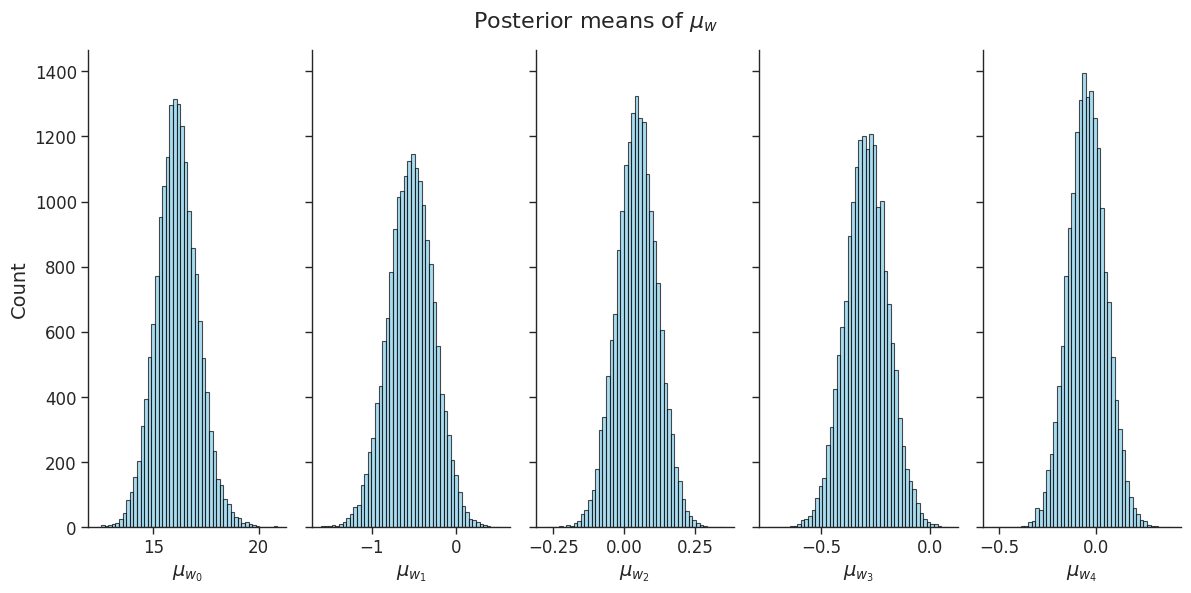

In [20]:
post_mu_w = posterior_samples_mu_w[:,burn_in:,:] # (num_chains, num_iterations, num_inputs)
post_mu_w = post_mu_w.reshape(-1, num_inputs) # collapse samples over the chains

fig, axs = plt.subplots(1, num_inputs, sharey=True, figsize=(12, 6))
for d, ax in enumerate(axs):
    ax.hist(post_mu_w[:,d], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_xlabel(r"$\mu_{{w_{:d}}}$".format(d))
    if d == 0: ax.set_ylabel("Count")
plt.suptitle(r"Posterior means of $\mu_w$", fontsize=16)
plt.tight_layout()
plt.show()

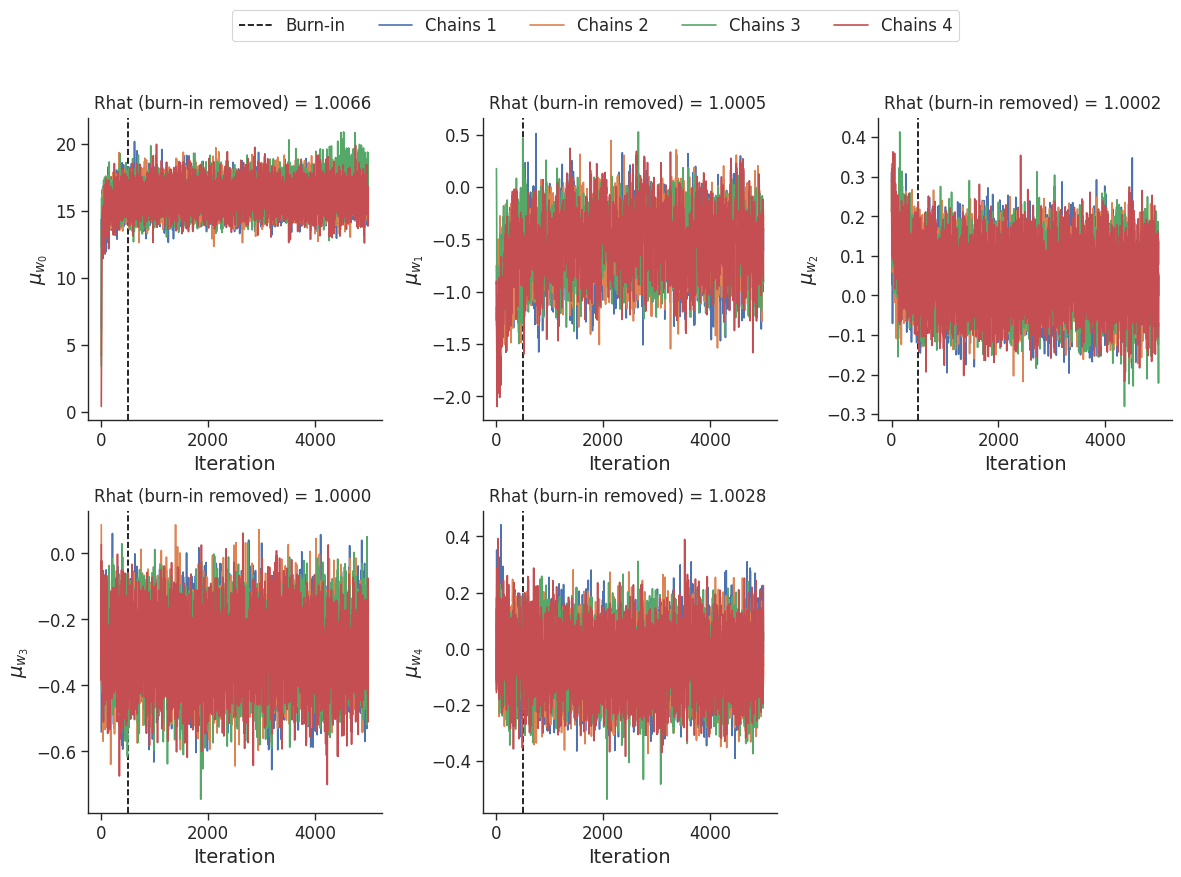

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

fig.delaxes(axes[-1])  # Removes the last (6th) axis (if num_inputs is 5)

for j in range(posterior_samples_mu_w.shape[2]):
    ax = axes[j]
    ax.axvline(x = burn_in, color = 'black', linestyle='dashed', label = 'Burn-in')
    
    for i in range(posterior_samples_mu_w.shape[0]):  # looping over chains
        ax.plot(posterior_samples_mu_w[i, :, j], label=f"Chains {i+1}")
    
    ax.set_xlabel("Iteration")
    ax.set_ylabel(f"$\mu_{{w_{j}}}$")
    ax.annotate(r'Rhat (burn-in removed) = {:.4f}'.format(calculate_r_hat(posterior_samples_mu_w[:, burn_in:, j])), xy=(0.02, 1.03), size= 12, xycoords='axes fraction')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=12, ncol=6)
plt.tight_layout()
plt.show()


#### Hypothesis testing $\mu_w$

In [22]:
"""

The posteriors distributions of the group-level mu_w can be used to assess the significance
of a predictor variable. To do so, we use zero as cutoff and check which side (left or right)
has the smallest tail. Next, we calculate the area of this smallest tail and multiply by two 
(to perform two-sided hypothesis testing). The resulting value is the p-value!

Note that performing a one sample t-test against zero based on the per-subject w's is not correct.
Due to the hierarchical nature of hMFC, these per-subject estimates are not independent.
In contrast, the t-test assumes these values to be independent.

"""

variable_index = 0 # which of the w's you want to test

if jnp.median(post_mu_w[:,variable_index]) < 0: # right tail is the smallest
    p_value = (sum(post_mu_w[:,variable_index] > 0)/len(post_mu_w[:,variable_index]))*2
    
else: # left tail is smallest
    p_value = (sum(post_mu_w[:,variable_index] < 0)/len(post_mu_w[:,variable_index]))*2

if p_value < .05:
    outcome = "significantly"
else: 
    outcome = "not significantly"
    
print(r"The posterior of w"+str(variable_index)+" with mean "+str(jnp.round(jnp.mean(post_mu_w[:,variable_index]),decimals=4))+" is "+str(outcome)+" different from 0 (p="+str(p_value)+")")


The posterior of w0 with mean 16.1243 is significantly different from 0 (p=0.0)


#### Posterior distribution of $\sigma_w$

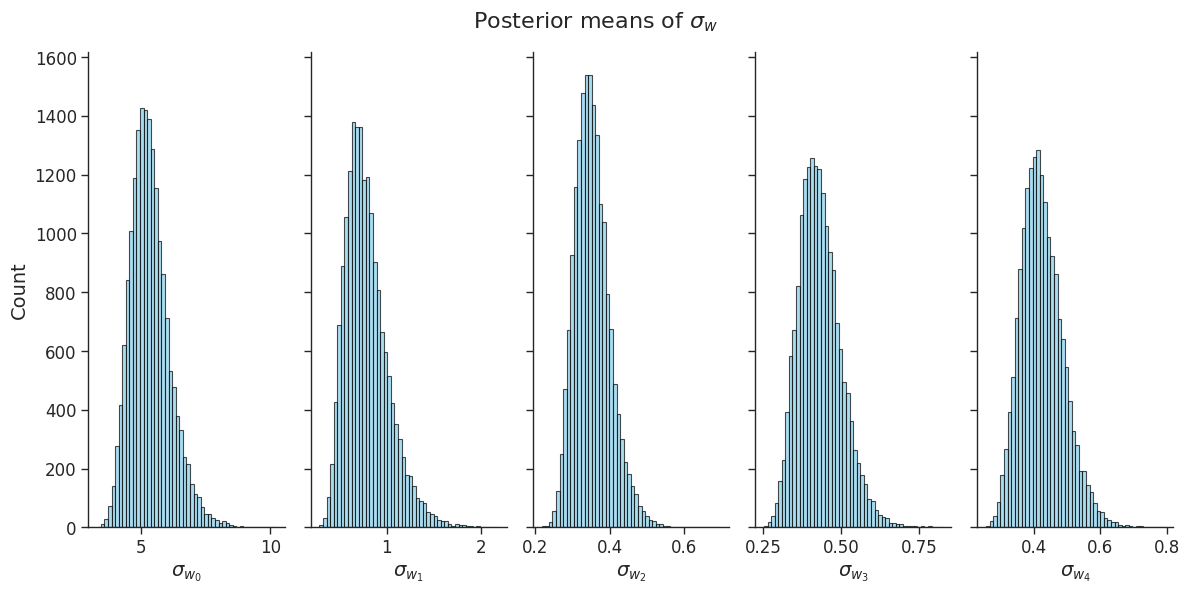

In [23]:
post_sigma_w = posterior_samples_sigma_w[:,burn_in:,:] # (num_chains, num_iterations, num_inputs)
post_sigma_w = post_sigma_w.reshape(-1, num_inputs) # collapse samples over the chains

fig, axs = plt.subplots(1, num_inputs, sharey=True, figsize=(12, 6))
for d, ax in enumerate(axs):
    ax.hist(post_sigma_w[:,d], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_xlabel(r"$\sigma_{{w_{:d}}}$".format(d))
    if d == 0: ax.set_ylabel("Count")
plt.suptitle(r"Posterior means of $\sigma_w$", fontsize=16)
plt.tight_layout()
plt.show()

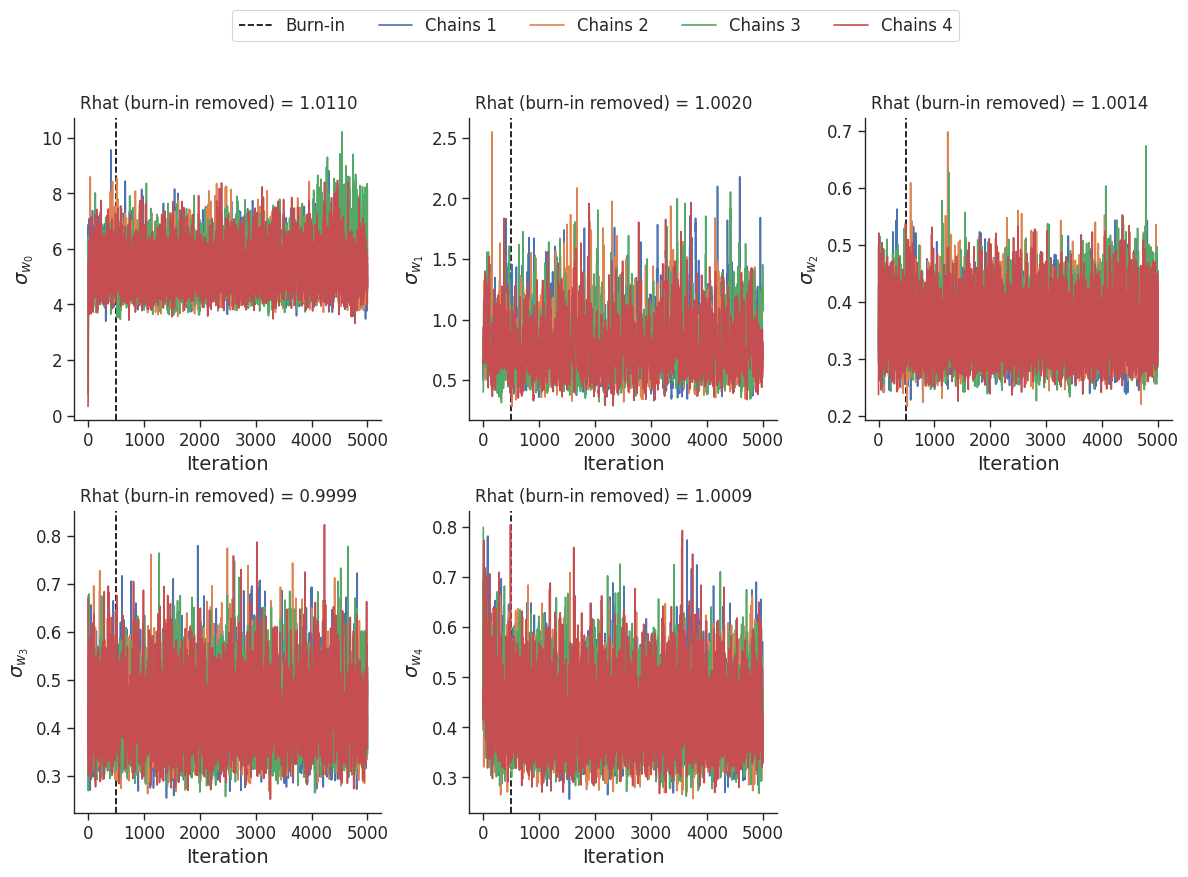

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

fig.delaxes(axes[-1])  # Removes the last (6th) axis (if num_inputs is 5)

for j in range(posterior_samples_sigma_w.shape[2]):
    ax = axes[j]
    ax.axvline(x = burn_in, color = 'black', linestyle='dashed', label = 'Burn-in')
    
    for i in range(posterior_samples_sigma_w.shape[0]):  # looping over chains
        ax.plot(posterior_samples_sigma_w[i, :, j], label=f"Chains {i+1}")
    
    ax.set_xlabel("Iteration")
    ax.set_ylabel(f"$\sigma_{{w_{j}}}$")
    ax.annotate(r'Rhat (burn-in removed) = {:.4f}'.format(calculate_r_hat(posterior_samples_sigma_w[:, burn_in:, j])), xy=(0.02, 1.03), size= 12, xycoords='axes fraction')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=12, ncol=6)
plt.tight_layout()
plt.show()

#### Posterior distribution of $\mu_a$

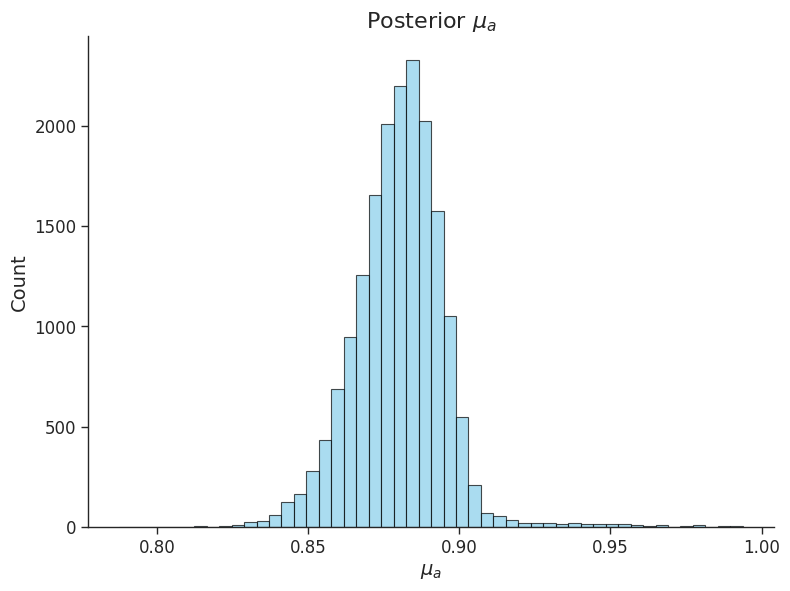

In [25]:
post_mu_a = posterior_samples_mu_a[:,burn_in:] # (num_chains, num_iterations)
post_mu_a = post_mu_a.reshape(-1) # collapse samples over the chains

plt.figure(figsize=(8, 6))
plt.hist(post_mu_a, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel(r"$\mu_a$")
plt.ylabel("Count")
plt.title(r"Posterior $\mu_a$")
plt.tight_layout()
plt.show()

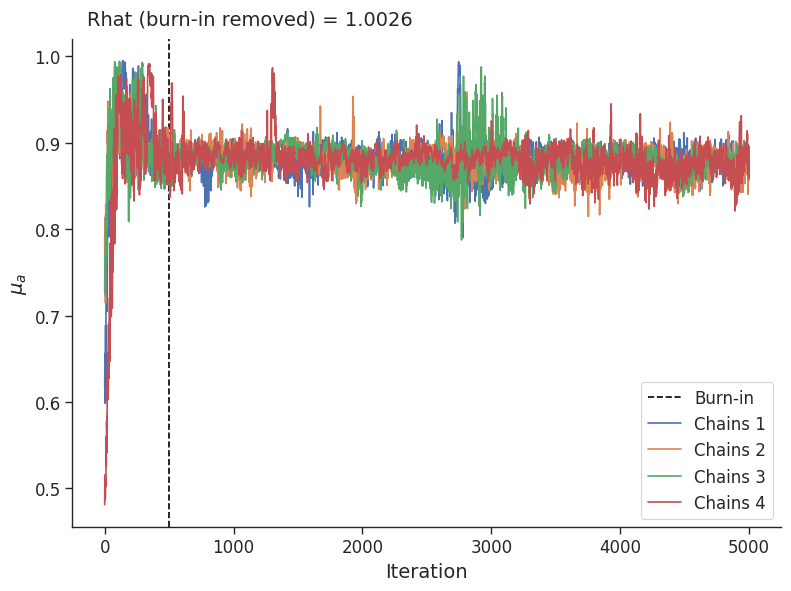

In [26]:
plt.figure(figsize=(8, 6))
plt.axvline(x = burn_in, color = 'black', linestyle='dashed', label = 'Burn-in')
for i in range(posterior_samples_mu_a.shape[0]): # looping over chains
    plt.plot(posterior_samples_mu_a[i, :], label=f"Chains {i+1}")
plt.xlabel("Iteration")
plt.ylabel(r"$\mu_{{a}}$")
plt.annotate(r'Rhat (burn-in removed) = {:.4f}'.format(calculate_r_hat(posterior_samples_mu_a[:,burn_in:])), xy=(0.02, 1.03), size= 14, xycoords='axes fraction')
plt.legend(fontsize=12) 
plt.tight_layout()
plt.show()

#### Posterior distribution of $\sigma_a$

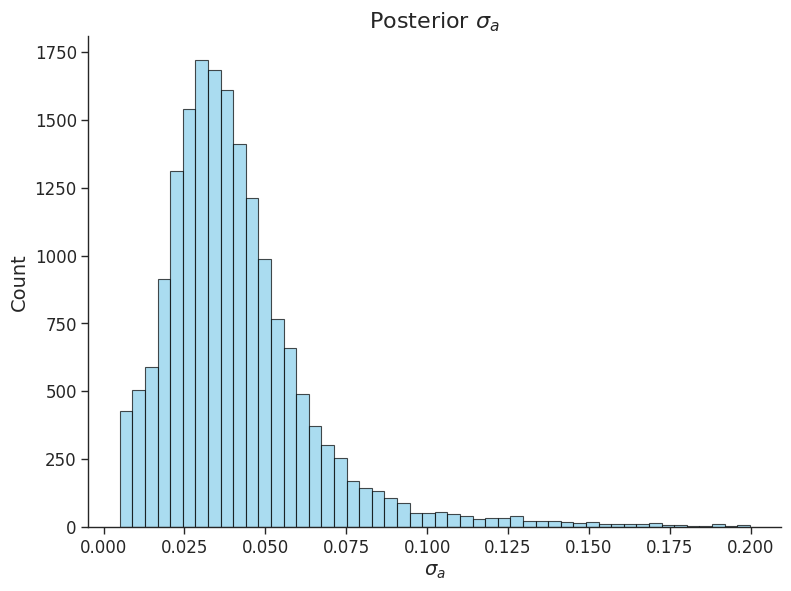

In [27]:
post_sigma_a = posterior_samples_sigma_a[:,burn_in:] # (num_chains, num_iterations)
post_sigma_a = post_sigma_a.reshape(-1) # collapse samples over the chains

plt.figure(figsize=(8, 6))
plt.hist(post_sigma_a, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel(r"$\sigma_a$")
plt.ylabel("Count")
plt.title(r"Posterior $\sigma_a$")
plt.tight_layout()
plt.show()  

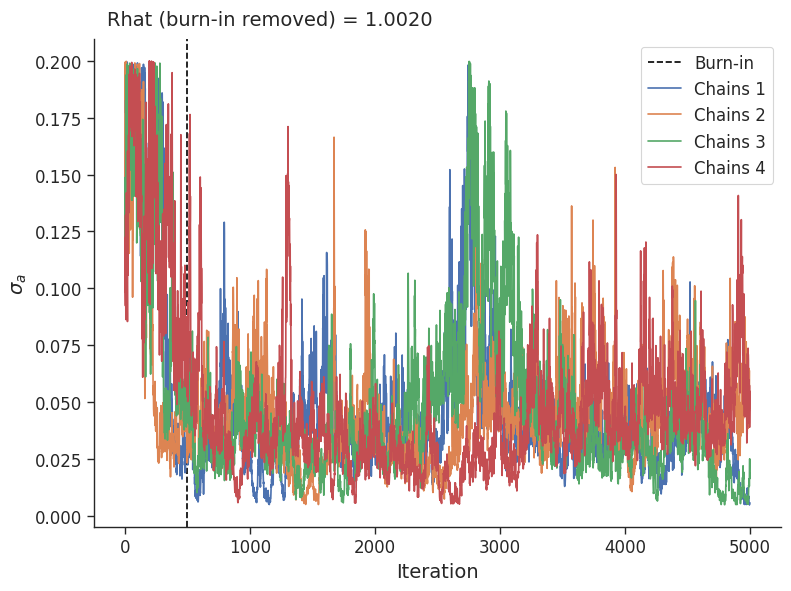

In [28]:
plt.figure(figsize=(8, 6))
plt.axvline(x = burn_in, color = 'black', linestyle='dashed', label = 'Burn-in')
for i in range(posterior_samples_sigma_a.shape[0]): # looping over chains
    plt.plot(posterior_samples_sigma_a[i, :], label=f"Chains {i+1}")
plt.xlabel("Iteration")
plt.ylabel(r"$\sigma_{{a}}$")
plt.annotate(r'Rhat (burn-in removed) = {:.4f}'.format(calculate_r_hat(posterior_samples_sigma_a[:,burn_in:])), xy=(0.02, 1.03), size= 14, xycoords='axes fraction')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#### Posterior distribution of $\mu_{\sigma^2}$

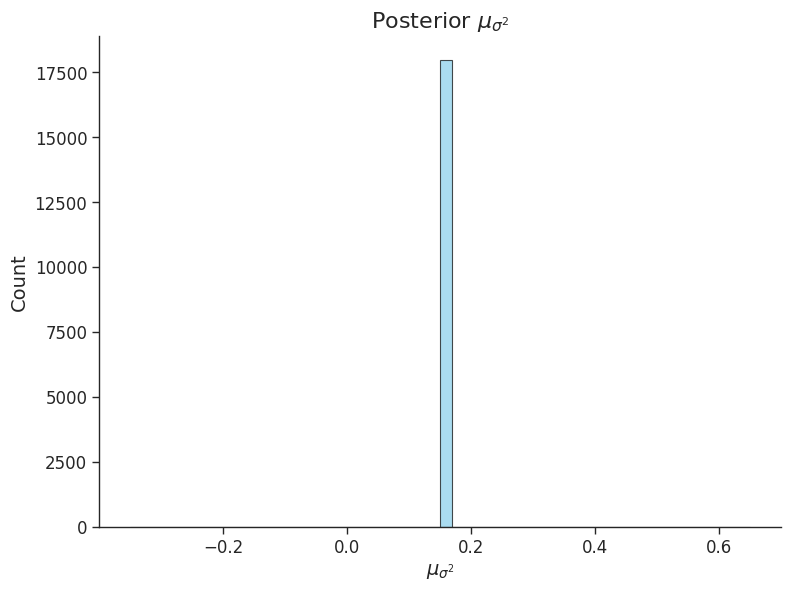

In [29]:
post_mu_sigmasq = posterior_samples_mu_sigmasq[:,burn_in:] # (num_chains, num_iterations)
post_mu_sigmasq = post_mu_sigmasq.reshape(-1) # collapse samples over the chains

plt.figure(figsize=(8, 6))
plt.hist(post_mu_sigmasq, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel(r"$\mu_{\sigma^2}$")
plt.ylabel("Count")
plt.title(r"Posterior $\mu_{\sigma^2}$")
plt.tight_layout()
plt.show()

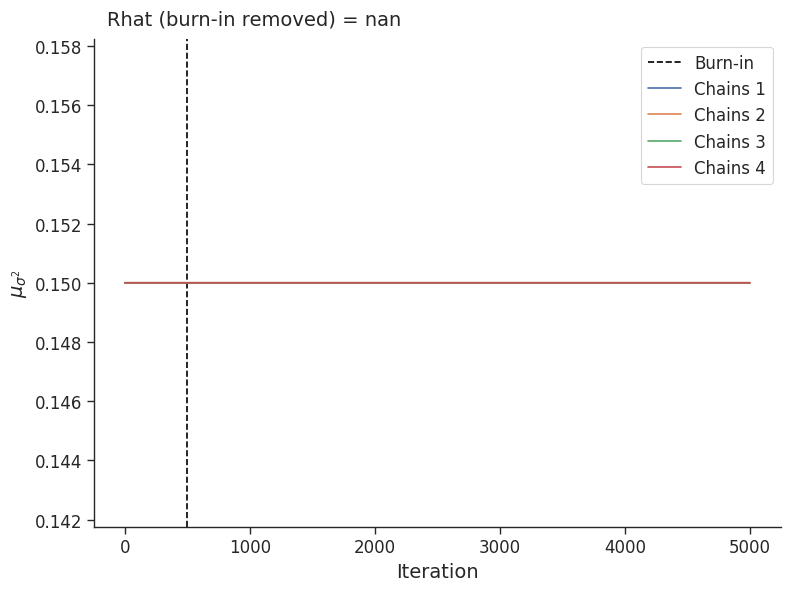

In [30]:
plt.figure(figsize=(8, 6))
plt.axvline(x = burn_in, color = 'black', linestyle='dashed', label = 'Burn-in')
for i in range(posterior_samples_mu_sigmasq.shape[0]): # looping over chains
    plt.plot(posterior_samples_mu_sigmasq[i, :], label=f"Chains {i+1}")
plt.xlabel("Iteration")
plt.ylabel(r"$\mu_{\sigma^2}$")
plt.annotate(r'Rhat (burn-in removed) = {:.4f}'.format(calculate_r_hat(posterior_samples_mu_sigmasq[:,burn_in:])), xy=(0.02, 1.03), size= 14, xycoords='axes fraction')
plt.legend(fontsize=12) 
plt.tight_layout()
plt.show()

#### Posterior distribution of $\beta_{\sigma2}$

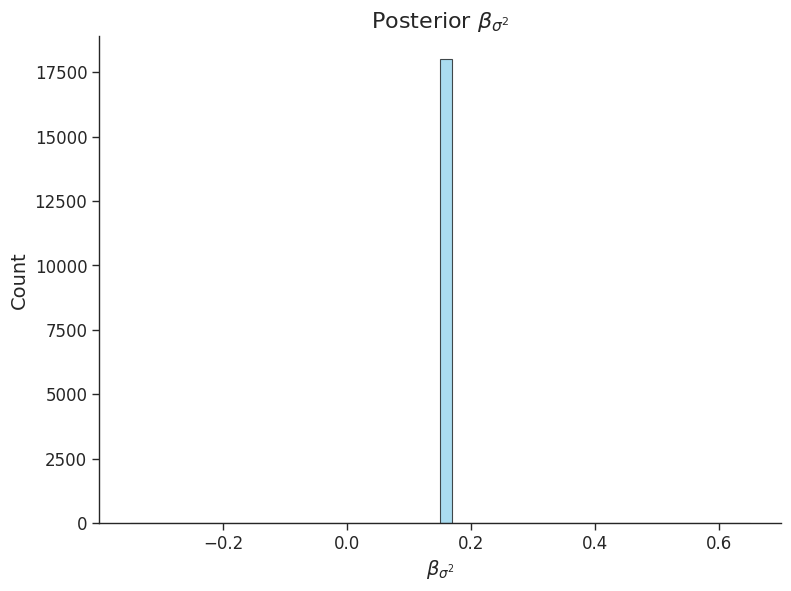

In [31]:
post_beta_sigmasq = posterior_samples_beta_sigmasq[:,burn_in:] # (num_chains, num_iterations)
post_beta_sigmasq = post_beta_sigmasq.reshape(-1) # collapse samples over the chains

plt.figure(figsize=(8, 6))
plt.hist(post_beta_sigmasq, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel(r"$\beta_{\sigma^2}$")
plt.ylabel("Count")
plt.title(r"Posterior $\beta_{\sigma^2}$")
plt.tight_layout()
plt.show()

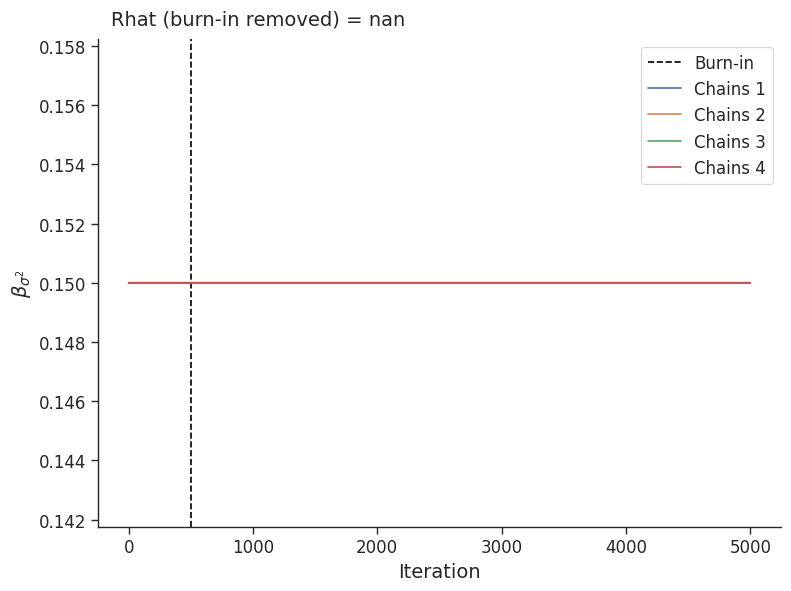

In [32]:
plt.figure(figsize=(8, 6))
plt.axvline(x = burn_in, color = 'black', linestyle='dashed', label = 'Burn-in')
for i in range(posterior_samples_beta_sigmasq.shape[0]): # looping over chains
    plt.plot(posterior_samples_beta_sigmasq[i, :], label=f"Chains {i+1}")
plt.xlabel("Iteration")
plt.ylabel(r"$\beta_{\sigma^2}$")
plt.annotate(r'Rhat (burn-in removed) = {:.4f}'.format(calculate_r_hat(posterior_samples_beta_sigmasq[:,burn_in:])), xy=(0.02, 1.03), size= 14, xycoords='axes fraction')
plt.legend(fontsize=12) 
plt.tight_layout()
plt.show()

#### Posterior distribution of $\sigma_{\mu_x}$

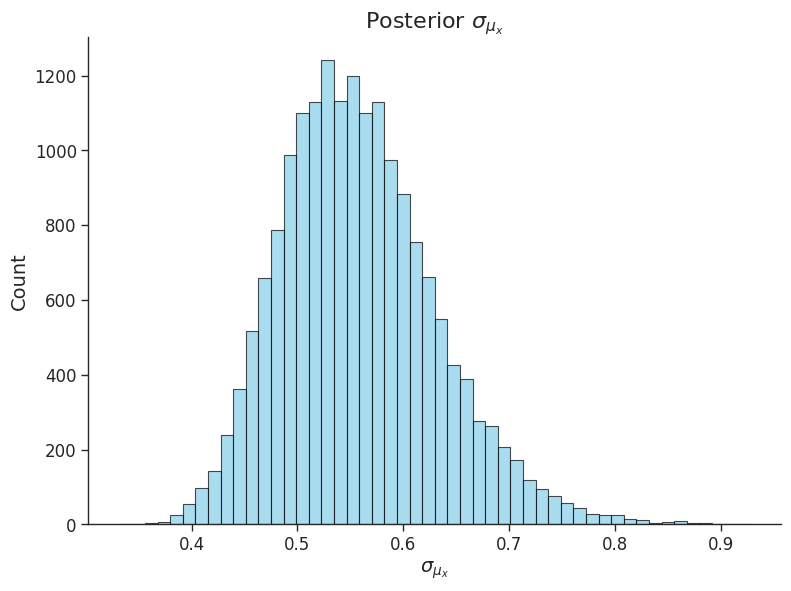

In [33]:
post_sigma_mu_x = posterior_samples_sigma_mu_x[:,burn_in:] # (num_chains, num_iterations)
post_sigma_mu_x = post_sigma_mu_x.reshape(-1) # collapse samples over the chains

plt.figure(figsize=(8, 6))
plt.hist(post_sigma_mu_x, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel(r"$\sigma_{\mu_x}$")
plt.ylabel("Count")
plt.title(r"Posterior $\sigma_{\mu_x}$")
plt.tight_layout()
plt.show()

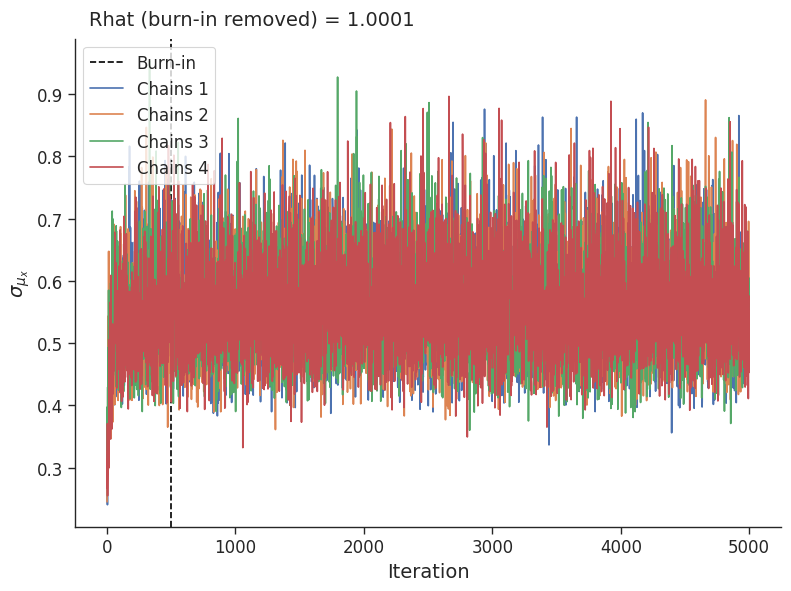

In [34]:
plt.figure(figsize=(8, 6))
plt.axvline(x = burn_in, color = 'black', linestyle='dashed', label = 'Burn-in')
for i in range(posterior_samples_sigma_mu_x.shape[0]): # looping over chains
    plt.plot(posterior_samples_sigma_mu_x[i, :], label=f"Chains {i+1}")
plt.xlabel("Iteration")
plt.ylabel(r"$\sigma_{\mu_x}$")
plt.annotate(r'Rhat (burn-in removed) = {:.4f}'.format(calculate_r_hat(posterior_samples_sigma_mu_x[:,burn_in:])), xy=(0.02, 1.03), size= 14, xycoords='axes fraction')
plt.legend(fontsize=12) 
plt.tight_layout()
plt.show()